#  Разработка модульного чат-бота с применением моделей 🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/models?pipeline_tag=token-classification&sort=trending
* https://huggingface.co/docs/transformers/training
* https://github.com/seatgeek/thefuzz
* https://github.com/pytransitions/transitions
* https://github.com/gunthercox/ChatterBot
* https://deeppavlov.ai/

## Задачи для совместного разбора

1\. Рассмотрите типовые шаги для создания вопрос-ответного бота.

In [ ]:
db = {
    "film_director": {
        "Титаник": "Кэмерон",
        "Гибель «Титаника»": "Бейкер"
    }
}

In [ ]:
question = "Кто режиссер Титаника"

In [ ]:
!pip install thefuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.7 MB/s eta 0:00:00


In [ ]:
from thefuzz import process

In [ ]:
def get_intent(question): # намерение вопроса
  return "film_director"

def get_entity(question, intent): # сущность вопроса
  return "Титаника"

def get_answer(intent, entity): # получить ответ на вопрос
  data = db["film_director"]   # получает данные по намерению из базы
  entity = process.extractOne(entity, data.keys())[0]  # находит наиболее подходящее название фильма с thefuzz для нечеткого сравнения сущности с ключами в базе
  answer = data[entity] # возвращает соответствующего режиссера
  return answer

In [ ]:
question = "Кто режиссер Титаника"
intent = get_intent(question) # намерение вопроса (узнаьб кто film_director)
entity = get_entity(question, intent) # сущность вопроса ("Титаника")
answer = get_answer(intent, entity) # получить ответ на вопрос (Кэмерон)
answer

'Кэмерон'

2\. Обсудите возможности пакета `transitions` для создания машины состояний бота.

## Задачи для самостоятельного решения

### 1.

<p class="task" id="1"></p>

1\. Загрузите любую модель для распознавания именованных сущностей (NER) на русском языке из 🤗 Transformers. Напишите функцию `get_entity`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [x] Проверено на семинаре

In [ ]:
def get_entity(question: str) -> dict:
    """
    Пример question: "Кто является оператором фильма Андеграунд"
    Возвращает словарь следующего вида
        {
            "score": 0.8,
            "word": "фильма Андеграунд",
        }

    """
    pass

In [ ]:
import zipfile
import os

extract_to = os.path.splitext('qst_csv.zip')[0]
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile('qst_csv.zip', 'r') as zip_ref:
  zip_ref.extractall(extract_to)

extract_to

'qst_csv'

In [ ]:
import pandas as pd

data = []
dir = '/content/qst_csv/qst_csv/questions'

for filename in os.listdir(dir):
  if filename.endswith('.csv'):
    intent = filename.replace('.csv', '')

    filepath = os.path.join(dir, filename)
    with open(filepath, 'r', encoding='utf-8') as f:
      first_line = f.readline()
      questions = f.read().splitlines()

    for question in questions:
          data.append({
              'question': question.strip(),
              'intent': f'{intent}'
          })

df = pd.DataFrame(data)

df.head()

,question,intent
0,Кто сыграл в главных ролях Друзья,film_actors
1,Кто в главных ролях Матрица,film_actors
2,Кто играл главные роли в фильме Даун Хаус,film_actors
3,Спартак актеры в главных ролях,film_actors
4,Перечисли актеров которые играют главные роли ...,film_actors


In [ ]:
df['intent'].value_counts()

,count
intent,
film_cameraman,261
film_director,252
film_actors,200


In [ ]:
questions = df['question'].to_list()
questions[:5]

['Кто сыграл в главных ролях Друзья',
 'Кто в главных ролях Матрица',
 'Кто играл главные роли в фильме Даун Хаус',
 'Спартак актеры в главных ролях',
 'Перечисли актеров которые играют главные роли в фильме Мелодрама']

In [ ]:
from transformers import pipeline
nlp = pipeline("ner", model="Babelscape/wikineural-multilingual-ner")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def get_entity(question: str) -> dict:
    """
    Пример question: "Кто является оператором фильма Андеграунд"
    Возвращает словарь следующего вида
        {
            "score": 0.8,
            "word": "фильма Андеграунд",
        }

    """
    results = nlp(question)

    if not results:
        return {"score": 0.0, "word": ""}

    best_entity = max(results, key=lambda x: x['score']) # выбираю сущность с наибольшей уверенностью

    return {
        "score": float(best_entity['score']),
        "word": best_entity['word'].strip()
    }

for question in questions[:5]:
    result = get_entity(question)
    print(f"Вопрос: {question}")
    print(f"Сущность: {result['word']} (score: {result['score']})\n")

Вопрос: Кто сыграл в главных ролях Друзья
Сущность: Д (score: 0.6829262375831604)

Вопрос: Кто в главных ролях Матрица
Сущность: М (score: 0.7773135900497437)

Вопрос: Кто играл главные роли в фильме Даун Хаус
Сущность: Х (score: 0.9780879020690918)

Вопрос: Спартак актеры в главных ролях
Сущность: Спартак (score: 0.439086377620697)

Вопрос: Перечисли актеров которые играют главные роли в фильме Мелодрама
Сущность: ##ма (score: 0.9900211691856384)



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification # чтоб норм обрабатывал текст !!!!
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner") # подготавливаем текст к формату понятному модели
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)
example = "Кто является оператором фильма Андеграунд"

ner_results = nlp(example)
print(ner_results)

Device set to use cuda:0


[{'entity_group': 'MISC', 'score': np.float32(0.9772676), 'word': 'Андеграунд', 'start': 31, 'end': 41}]


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [ ]:
def get_entity(question: str) -> dict:
    """
    Пример question: "Кто является оператором фильма Андеграунд"
    Возвращает словарь следующего вида
        {
            "score": 0.8,
            "word": "фильма Андеграунд",
        }

    """
    results = nlp(question)

    if not results:
        return {"score": 0.0, "word": ""}#, "type": ""}

    best_entity = max(results, key=lambda x: x['score']) # выбираю сущность с наибольшей уверенностью
    #entity_type = best_entity['entity_group']

    return {
        "score": float(best_entity['score']),
        "word": best_entity['word'].strip(),
        #"type": entity_type
    }

for question in questions[:5]:
    result = get_entity(question)
    print(f"Вопрос: {question}")
    print(f"Сущность: {result['word']} (score: {result['score']})\n")

Вопрос: Кто сыграл в главных ролях Друзья
Сущность: Друзь (score: 0.5635724067687988)

Вопрос: Кто в главных ролях Матрица
Сущность: Матрица (score: 0.6886329650878906)

Вопрос: Кто играл главные роли в фильме Даун Хаус
Сущность: Даун Хаус (score: 0.9501568078994751)

Вопрос: Спартак актеры в главных ролях
Сущность: Спартак (score: 0.439086377620697)

Вопрос: Перечисли актеров которые играют главные роли в фильме Мелодрама
Сущность: Мелодрама (score: 0.9726694822311401)



### 2.

<p class="task" id="2"></p>

2\. Загрузите любую модель для классификации текста на русском языке из 🤗 Transformers. Дообучите эту модель для задачи предсказания трех классов: film_actors, film_cameraman и film_director. При создании модели укажите маппинг индексов классов на названия.

Напишите функцию `get_intent`. Продемонстрируйте пример работы на нескольких примерах из файлов с вопросами из каталога `qst_csv/questions`.

- [x] Проверено на семинаре

In [ ]:
def get_intent(question: str) -> str:
    # Возвращает строку с интентом, например, film_cameraman
    pass

In [ ]:
label_map = {
    'film_actors': 0,
    'film_cameraman': 1,
    'film_director': 2
}
reverse_label_map = {v: k for k, v in label_map.items()}
reverse_label_map

{0: 'film_actors', 1: 'film_cameraman', 2: 'film_director'}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=reverse_label_map,
    label2id=label_map,
    ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

def tokenize_func(examples):
    return tokenizer(examples["question"], padding="max_length", truncation=True, max_length=128)

df['label'] = df['intent'].map(label_map)  # преобразую метки в числовой формат

train_df, test_df = train_test_split(df, test_size=0.2)
train_dataset = Dataset.from_pandas(train_df).map(tokenize_func, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_func, batched=True)

Map:   0%|          | 0/570 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    logging_steps=10,
    eval_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.239300,0.203170
2,0.059500,0.076272
3,0.044600,0.068987


TrainOutput(global_step=216, training_loss=0.2657749883278652, metrics={'train_runtime': 12.0098, 'train_samples_per_second': 142.383, 'train_steps_per_second': 17.985, 'total_flos': 3152884538880.0, 'train_loss': 0.2657749883278652, 'epoch': 3.0})

In [ ]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = model.to(device)

In [ ]:
def get_intent(question):
    inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True, max_length=128)  # токенизация вопроса

    inputs = {k: v.to(device) for k, v in inputs.items()}  # перемещаю на gpu тензоры

    with th.no_grad():
        logits = model(**inputs).logits  # получаем предсказания

    predicted_class = th.argmax(logits).item() # предсказанный класс

    return model.config.id2label[predicted_class]

In [ ]:
for question in (questions[:5]+questions[-5:]):
    intent = get_intent(question)
    print(f"Вопрос: {question}")
    print(f"Предсказанный интент: {intent}\n")

Вопрос: Кто сыграл в главных ролях Друзья
Предсказанный интент: film_actors

Вопрос: Кто в главных ролях Матрица
Предсказанный интент: film_actors

Вопрос: Кто играл главные роли в фильме Даун Хаус
Предсказанный интент: film_actors

Вопрос: Спартак актеры в главных ролях
Предсказанный интент: film_actors

Вопрос: Перечисли актеров которые играют главные роли в фильме Мелодрама
Предсказанный интент: film_actors

Вопрос: Кто стоял за камерой при съемке Матрица
Предсказанный интент: film_cameraman

Вопрос: Как зовут оператора фильма Начало
Предсказанный интент: film_cameraman

Вопрос: Кто выступил оператором в картине Бегущий по лезвию
Предсказанный интент: film_cameraman

Вопрос: Кто оператор матрицы
Предсказанный интент: film_cameraman

Вопрос: Кто был оператором фильма Крестный отец
Предсказанный интент: film_cameraman



In [ ]:
from random import sample

print(sample(questions,3))

['Кто оператор фильма Пираты карибского моря', 'Кто сыграл главные роли в Титаник', 'Кто сыграл главные роли в фильме Леон']


In [ ]:
for question in sample(questions,5):
    intent = get_intent(question)
    print(f"Вопрос: {question}")
    print(f"Предсказанный интент: {intent}\n")

Вопрос: Кто продюсировал фильм Выживший
Предсказанный интент: film_director

Вопрос: Кто продюсировал Покемон Детектив Пикачу
Предсказанный интент: film_director

Вопрос: Кто продюсировал Призрак
Предсказанный интент: film_director

Вопрос: Как звали актеров фильма Апгрейд
Предсказанный интент: film_actors

Вопрос: Какие артисты были в главных ролях сериале Дальнобойщики
Предсказанный интент: film_actors



### 3.

<p class="task" id="3"></p>

3\. Создайте словарь `db` следующего вида:
```
{
    "film_director": {
        "Т 34": "Алексей Сидоров (Aleksey Sidorov)",
        "Матч": "Андрей Малюков (Andrey Malyukov)",
        ...
    },
    ...
}
```

Напишите функцию `find_answer`. Продемонстрируйте работоспособность на нескольких примерах.

- [ ] Проверено на семинаре

In [ ]:
def find_answer(entity: str, intent: str, db: dict) -> tuple[str, int]:
    """entity - результат работы get_entity,intent - результат работы get_intent
    Для поиска ключа в словаре db[intent] воспользуйтесь методом process.extractOne из пакета thefuzz
    """
    pass

In [ ]:
!pip install thefuzz

In [ ]:
def create_db(data_dir):
  db = {
      "film_director": {},
      "film_cameraman": {},
      "film_actors": {},
      "film_producer": {}
    }

  for intent in db.keys():
    filepath = os.path.join(data_dir, 'answers', f'{intent}.csv')
    if os.path.exists(filepath):
      df = pd.read_csv(filepath, header=None, skiprows=1, names=['film', 'answer'])
      for _, row in df.iterrows():
        film = row['film'].strip()
        answer = row['answer'].strip()
        db[intent][film] = answer

  return db

db = create_db('/content/qst_csv/qst_csv')
db

{'film_director': {'Т 34': 'Алексей Сидоров (Aleksey Sidorov)',
  'Матч': 'Андрей Малюков (Andrey Malyukov)',
  'Тренер': 'Дэвид О. Расселл (David O. Russell)',
  'Парк юрского периода часть 1': 'Стивен Спилберг (Steven Spielberg)',
  'Сталинград': 'Федор Бондарчук (Fyodor Bondarchuk)',
  'Мстители,Финал': 'Энтони Руссо (Anthony Russo) и Джо Руссо (Joe Russo)',
  'Игра престолов (сериал)': 'Дэвид Бениофф и Д. Б. Уайсс (David Benioff, D. B. Weiss)',
  'Мальчишник в Вегасе': 'Тодд Филлипс (Todd Phillips)',
  'Парк юрского периода часть 2': 'Жан-Жак Анно (J.A. Bayona)',
  'Над пропастью во ржи': 'Марк Райделл (Mark Rydell)',
  'Криминальное чтиво': 'Квентин Тарантино (Quentin Tarantino)',
  'Окулус': 'Майк Флэнаган (Mike Flanagan)',
  'Я шагаю по Москве': 'Георгий Данелия (Georgiy Daneliya)',
  'Клон': 'Агнешка Холланд (Agnieszka Holland)',
  'Эйс Вентура,Розыск домашних животных': 'Том Шедьяк (Tom Shadyac)',
  'Золушка': 'Кеннет Брана (Kenneth Branagh)',
  'Богемская рапсодия': 'Брайан С

In [ ]:
def find_answer(entity: str, intent: str, db: dict) -> tuple[str, int]:
    """entity - результат работы get_entity,intent - результат работы get_intent
    Для поиска ключа в словаре db[intent] воспользуйтесь методом process.extractOne из пакета thefuzz
    """
    if intent not in db:
      return 'неизвестный интент',0

    films = list(db[intent].keys()) # список всех фильмов в данном интенте
    best_match = process.extractOne(entity, films)

    if best_match is None:
      return 'фильм не найден', 0

    film, confidence = best_match # наиболее похожий

    answer = db[intent][film]

    return answer, confidence

In [ ]:
test_cases = [
    ("Т 34", "film_director"),  # примеры
    ("Матч", "film_director"),
    ("Манюня", "film_director"),
    ("Андеграунд", "film_cameraman"),
    ("Брат", "film_actors")
]

for entity, intent in test_cases:
    answer, confidence = find_answer(entity, intent, db)
    print(f"Запрос: {entity} ({intent})")
    print(f"ответ: {answer} (уверенность: {confidence}%)")
    print()

Запрос: Т 34 (film_director)
ответ: Алексей Сидоров (Aleksey Sidorov) (уверенность: 100%)

Запрос: Матч (film_director)
ответ: Андрей Малюков (Andrey Malyukov) (уверенность: 100%)

Запрос: Манюня (film_director)
ответ: Андрей Малюков (Andrey Malyukov) (уверенность: 60%)

Запрос: Андеграунд (film_cameraman)
ответ: Александар Божович (Aleksandar Boshkovich) (уверенность: 100%)

Запрос: Брат (film_actors)
ответ: Сергей Бодров, Виктор Сухоруков. (уверенность: 100%)



### 4.

<p class="task" id="4"></p>

4\. Используя пакет `transitions`, опишите машину состояний следующего вида:

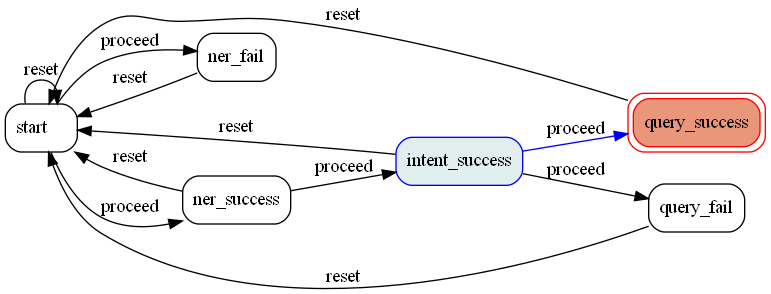

Реализуйте агента для ответов на вопросы по кино. Логика работы агента должна быть следующая:
* начинает в состоянии start;
* при вызове метода `proceed` в состоянии `start` вызывает `find_entity`, переходит в состояние `ner_success` и сохраняет найденное значение в виде атрибута `self.entity`, если сущность найдена, и переходит в `ner_fail` в противном случае;
* при вызове метода `proceed` в состоянии `ner_success` вызывает `find_intent`, переходит в состояние `intent_success` и сохраняет найденное значение в виде атрибута `self.intent`;
* при вызове метода `proceed` в состоянии `intent_success` вызывает `find_answer`, переходит в состояние `query_success` и сохраняет найденное значение в виде атрибута `self.answer`, если сущность найдена, и переходит в `query_fail` в противном случае;
* при вызове метода `reset` в любом состоянии переход в начальное состояние с сбрасывает значения атрибутов `self.entity`, `self.intent` и `self.answer`.

Если `find_entity` возвращает пустой результат или `score` меньше 0.3, то считайте, что сущность не найдена. Если find_answer возвращает score меньше 50, то считайте, что сущность не найдена.

Продемонстрируйте примеры работы агента.

- [ ] Проверено на семинаре

In [ ]:
!pip install transitions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
from transitions import Machine

class MovieAgent:
  def __init__(self):
    self.states = ['start', 'ner_success', 'ner_fail',
                   'intent_success', 'query_success', 'query_fail']

    self.entity = None
    self.intent = None
    self.answer = None

    self.machine = Machine(model=self, states=self.states, initial='start') # машина состояний

    self.machine.add_transition('proceed', 'start', None, after = '_process_ner')
    self.machine.add_transition('proceed', 'ner_success', None, after='_process_intent')
    self.machine.add_transition('proceed', 'intent_success', None, after='_process_query')
    self.machine.add_transition('reset', '*', 'start', before='_reset_attributes')

  def _reset_attributes(self):  # сбрасываем атрибуты при reset
    self.entity = None
    self.intent = None
    self.answer = None

  def _process_ner(self, question): # обрабатываем ner этап
    result = get_entity(question)
    if result and result['score']>0.3:
      self.entity = result['word']
      self.to_ner_success()
    else:
      self.to_ner_fail()

  def _process_intent(self, question):  # определяем интент
    self.intent = get_intent(question)
    self.to_intent_success()

  def _process_query(self): # ищем ответ
    self.answer = find_answer(self.entity, self.intent, db)[0]
    if find_answer(self.entity, self.intent, db)[1] > 0.3:
      self.to_query_success()
    else:
      self.to_query_fail()

  def process_question(self, question): # обрабатываем вопрос
    self.reset()
    print(f'Вопрос: {question}?')
    #print(f'Начальное состояние: {self.state}')

    # 1 этап - поиск сущности
    self.proceed(question)
    #print(f'\n(Состояние после поискa сущности: {self.state})')
    print(f'Сущность вопроса: {self.entity}')


    if self.state == 'ner_fail':
      return 'Не удалось определить сущность вопроса'

    # 2 этап - определение интента
    self.proceed(question)
    #print(f'\n(Состояние после определения интента: {self.state})')
    print(f'Намерение вопроса: {self.intent}')

    # 3 этап - поиск ответа
    self.proceed()
    #print(f'\n(Состояние после поиска ответа: {self.state})')
    print(f'Найденный ответ: {self.answer}\n')

    if self.state == 'query_fail':
      return self.answer

In [ ]:
agent = MovieAgent()   # тут вывожу по-старому чтобы посмотреть на состояния

questions = df['question']

for question in questions[:2]:
    agent.process_question(question)
    print('-----\n')

Вопрос: Кто сыграл в главных ролях Друзья?

(Состояние после поискa сущности: ner_success)
Сущность вопроса: Друзь

(Состояние после определения интента: intent_success)
Намерение вопроса: film_actors

(Состояние после поиска ответа: query_success)
Найденный ответ: Дженнифер Энистон, Куртни Кокс, Дэвид Швиммер, Лиса Кудроу, Мэттью Перри, Мэтт Леблан.

-----

Вопрос: Кто в главных ролях Матрица?

(Состояние после поискa сущности: ner_success)
Сущность вопроса: Матрица

(Состояние после определения интента: intent_success)
Намерение вопроса: film_actors

(Состояние после поиска ответа: query_success)
Найденный ответ: Киану Ривз, Лоуренс Фишбёрн

-----



In [ ]:
agent = MovieAgent()
questions = df['question'].to_list()

for question in sample(questions, 5):  # тут вывожу рандомные
    agent.process_question(question)
    print('-----\n')

Вопрос: Кто выступил продюсером ленты Титаник?
Сущность вопроса: Титаник
Намерение вопроса: film_director
Найденный ответ: Джеймс Кэмерон (James Cameron)

-----

Вопрос: Кто продюсировал фильм К звездам?
Сущность вопроса: К звездам
Намерение вопроса: film_director
Найденный ответ: Дэмиен Шазель (Damien Chazelle)

-----

Вопрос: Актеры из Отряда самоубийц?
Сущность вопроса: Отряда самоубийц
Намерение вопроса: film_actors
Найденный ответ: Уилл Смит, Марго Робби.

-----

Вопрос: Кто продюсер Последний рубеж?
Сущность вопроса: Последний рубеж
Намерение вопроса: film_director
Найденный ответ: Ким Джи-ун (Kim Jee-woon)

-----

Вопрос: Кто играет главных героев в фильме Унесенные ветром?
Сущность вопроса: Унесенные ветром
Намерение вопроса: film_actors
Найденный ответ: Вивьен Ли, Кларк Гейбл.

-----

